Sumire Honda 

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, label_binarize
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, RidgeClassifier, SGDClassifier, Perceptron
import scipy.stats as stats
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import csc_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, make_scorer, fbeta_score,plot_precision_recall_curve, precision_recall_curve, PrecisionRecallDisplay
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate, train_test_split

## Define a problem setting
***

### 1. Understanding requirements
   1. A bank wants to predict the creditworthiness of its customers
   2. It is five times more 'expensive' for the bank to rate a customer who is unworthy of credit as creditworthy than vice versa.
   3. Problems 1 (Data Availability)
        - Not all information is availbale for all customers. 
   4. Problem 2  (Data Availability and Representational Properties of Data)
        - The size of the Dataset is not large and the dataset is imbalanced in each category
        - Attributes has varying range of values and not all the values are numerical
   5. Problem 3 (Ethical Consideration)
        - Attributes "Personal status and sex" might cause the model's discriminative prediction in the future 

### 2. Deriving a solution and evaluation protocol
   1. Supervised Learning, Binary Classification
        - Data has y label and it is categorical (creditworthy or not worthy)
   2. Evaluation with F-beta score
        - The evaluation protoll should show 5 times higher risk for false positive than false negative
   3. Predict missing value with linear classification 
        - X: Completed feature / y: Imcomplete feature
        - Training with non-missing instances and predict the missing instances using linear classification
   4. Model selection and feature representation
        - Baseline: Decision Tree, RandomForest, (compared with Neural Network (MLP Classifier)) 
        - Elaboration: Hyperparameter tuning on the baseline model through nested cross validation
        - Z-Score normalization (When the feature distribution does not contain extreme outliers but with some outliers, it scales the range 0 to 1)
        
# Formal problem definition
***
##### A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P, if its performance at tasks in T, as measured by P, improves with experience E. 

* Task (T): Classify a bank costomer as creditworthy or not worthy of credit. 
* Experience (E): A dataset of 1000 representatively selected costomers' 20 features and the binary label of creditworthiness.   
* Performance (P): F-beta score ($F_{\alpha} = \frac{n_{TP} }{α(n_{TP} + n_{FP}) + (1-α)n_{TP} + n_{FN} }$, where $\alpha = \frac{1}{1 + \beta}$) where $\beta$ parameter determines 5 times more weight to precision than recall. ($\beta\  = 0.2$).


* Input: training sample 𝐱 ∈ 𝑋
* Output: Binary label 𝑦 ∈ 𝑌 = {creditworthy = 1, not worthy = 0}



### Read Data

In [3]:
df = pd.read_csv("C:/Users/hsmr0/OneDrive/デスクトップ/cogsys/ML/credit/data/kredit.dat", 
                 sep="\s+",                 
                 names=["Status", "Duration", "History", "Purpose (incomplete)", "Credit Amount", "Saving", "Present employment (incomplete)", "Installment rate", "Personal status & sex", "Debtors / guarantors", "Present residence", "Property", "Age", "Other Installment", "Housing", "Existing credits", "Job (incomplete)", "Num of liable people", "Telephone", "Foreign worker (incomplete)", "Creditworthy"])
df.reset_index(drop = True, inplace = True) # Modify the df in place (do not create a new object)
df.head()

,Status,Duration,History,Purpose (incomplete),Credit Amount,Saving,Present employment (incomplete),Installment rate,Personal status & sex,Debtors / guarantors,...,Property,Age,Other Installment,Housing,Existing credits,Job (incomplete),Num of liable people,Telephone,Foreign worker (incomplete),Creditworthy
0,A14,36,A32,?,2299,A63,?,4,A93,A101,...,A123,39,A143,A152,1,A173,1,A191,?,1
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,...,A124,61,A143,A153,1,?,1,A191,A201,1
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,...,A124,38,A141,A153,1,?,2,A191,?,2
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,...,A121,33,A141,A152,2,A173,1,A191,A201,1
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,...,A123,34,A143,A152,1,A173,2,A192,A201,1


* 1000 instances with the index of 0 to 999.
* 21 columns for 20 features and a y label "Creditworthiness". 
* There are missing values "?". 
* The data is of continuous features and discrete categorical features.
* y label Creditworthiness is predicted either category 1 or 2. 

## Data Analysis


Display the information about the data frame

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Status                           1000 non-null   object
 1   Duration                         1000 non-null   int64 
 2   History                          1000 non-null   object
 3   Purpose (incomplete)             1000 non-null   object
 4   Credit Amount                    1000 non-null   int64 
 5   Saving                           1000 non-null   object
 6   Present employment (incomplete)  1000 non-null   object
 7   Installment rate                 1000 non-null   int64 
 8   Personal status & sex            1000 non-null   object
 9   Debtors / guarantors             1000 non-null   object
 10  Present residence                1000 non-null   int64 
 11  Property                         1000 non-null   object
 12  Age                              10

Display its main statistical characteristics

In [34]:
# Numerical features 
continuous = df.select_dtypes(include='int64') 
continuous.drop("Creditworthy", axis=1).describe() 

,Duration,Credit Amount,Installment rate,Present residence,Age,Existing credits,Num of liable people
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


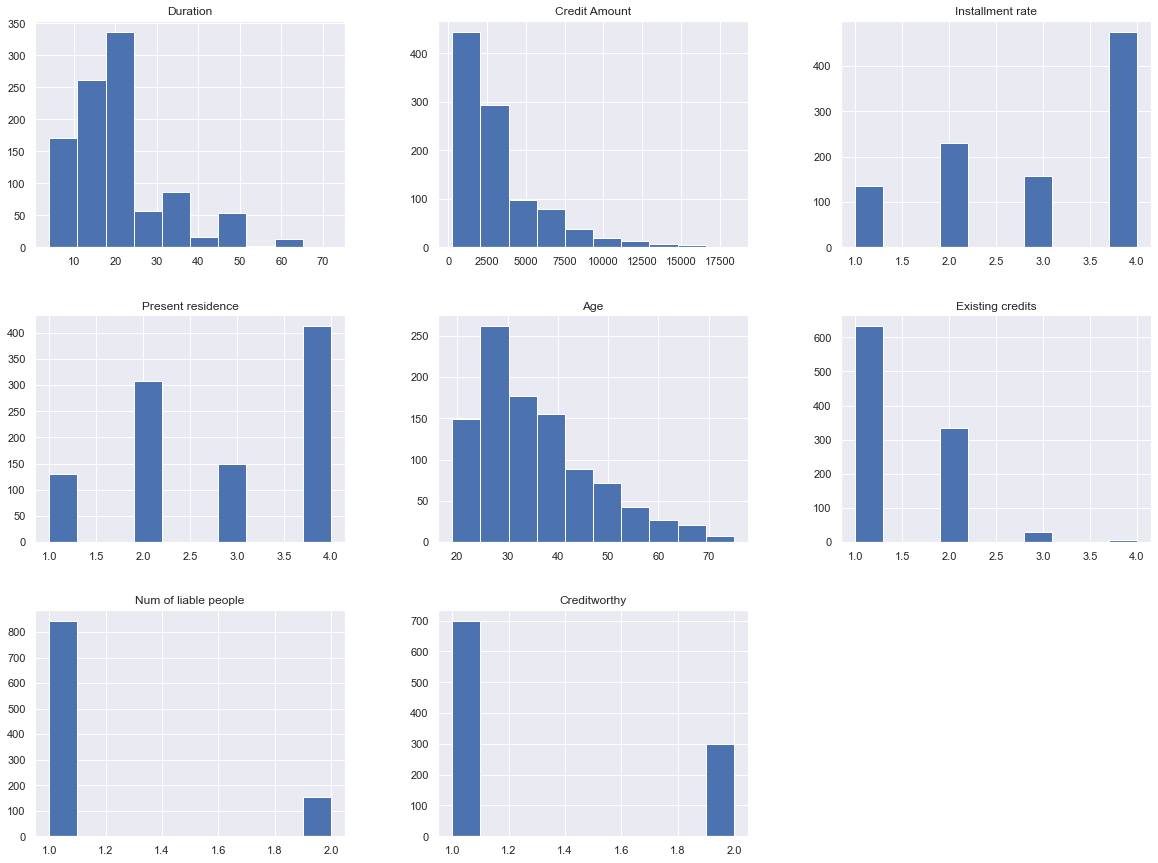

In [35]:
# Plot the data distribution in numerical feature
continuous.hist(figsize=(20,15));

In [36]:
# Categorical features  
cat = df.select_dtypes(include='object')
cat.describe()

,Status,History,Purpose (incomplete),Saving,Present employment (incomplete),Personal status & sex,Debtors / guarantors,Property,Other Installment,Housing,Job (incomplete),Telephone,Foreign worker (incomplete)
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,4,5,11,5,6,4,3,4,3,3,5,2,3
top,A14,A32,A43,A61,?,A93,A101,A123,A143,A152,A173,A191,A201
freq,394,530,226,603,496,548,907,332,814,713,484,596,613


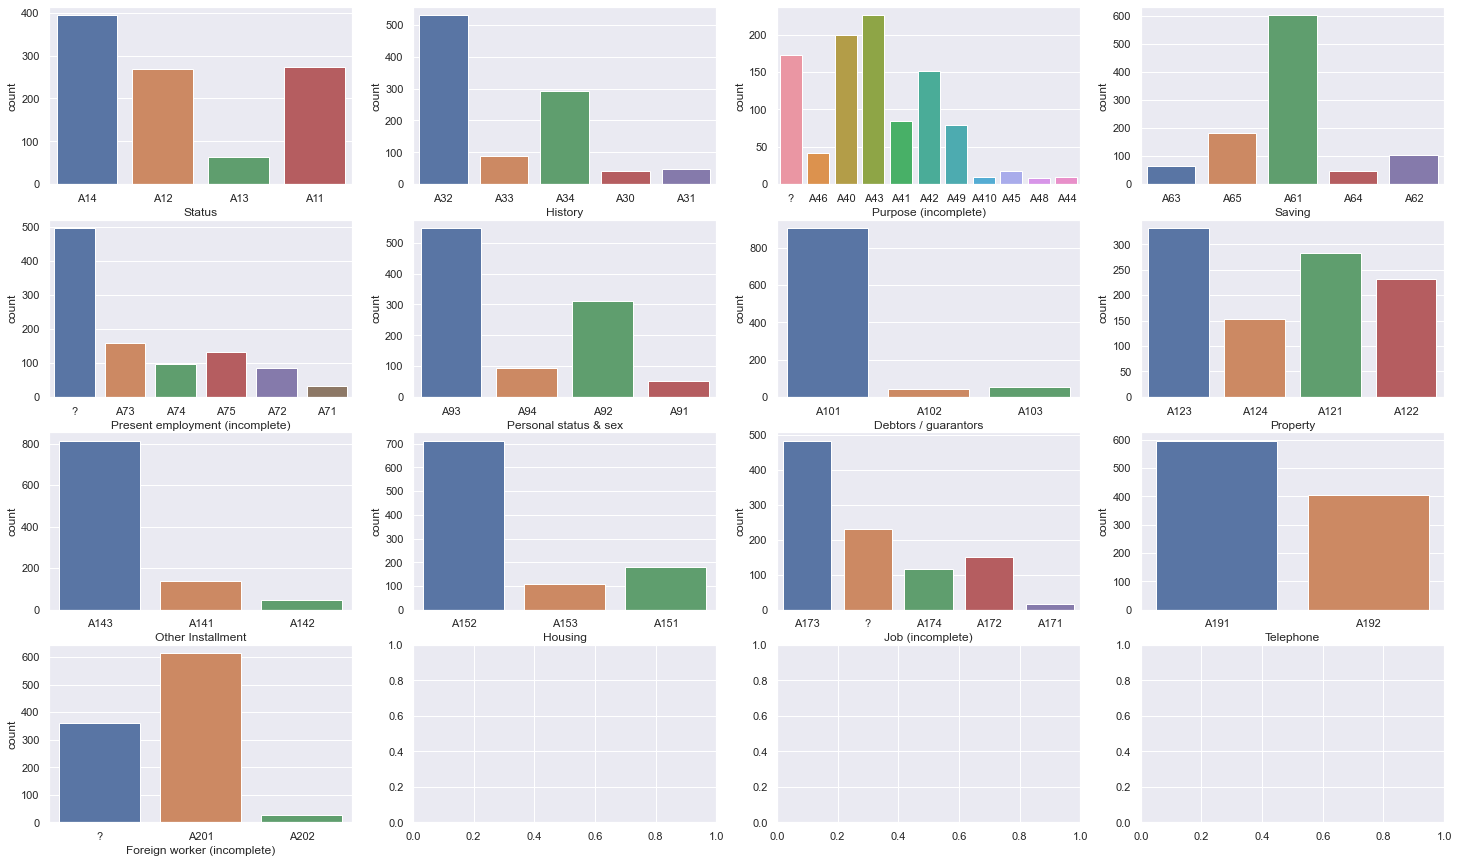

In [38]:
# Plot the data distribution in categorical features
sns.set()
fig, axes = plt.subplots(4, 4, figsize=(25,15))
ax = sns.countplot(x="Status", data=cat,ax=axes[0,0])
ax = sns.countplot(x="History", data=cat, ax=axes[0,1])
ax = sns.countplot(x="Purpose (incomplete)", data=cat, ax=axes[0,2])
ax = sns.countplot(x="Saving", data=cat, ax=axes[0,3])
ax = sns.countplot(x="Present employment (incomplete)", data=cat, ax=axes[1,0])
ax = sns.countplot(x="Personal status & sex", data=cat, ax=axes[1,1])
ax = sns.countplot(x="Debtors / guarantors", data=cat, ax=axes[1,2])
ax = sns.countplot(x="Property", data=cat, ax=axes[1,3])
ax = sns.countplot(x="Other Installment", data=cat, ax=axes[2,0])
ax = sns.countplot(x="Housing", data=cat, ax=axes[2,1])
ax = sns.countplot(x="Job (incomplete)", data=cat, ax=axes[2,2])
ax = sns.countplot(x="Telephone", data=cat, ax=axes[2,3])
ax = sns.countplot(x="Foreign worker (incomplete)", data=cat, ax=axes[3,0])


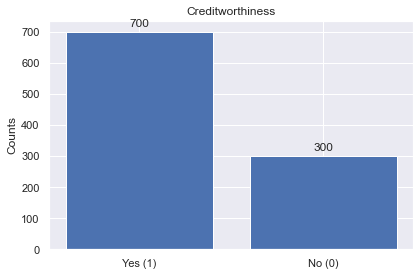

In [225]:
# Creditworthy label distribution
labels = ["Yes (1)","No (0)"]
x = [1, 2] # X axis location
width = 0.35
yes_no= [700, 1000-700]

fig, ax = plt.subplots()
rect1 = ax.bar(x, yes_no)

ax.set_ylabel('Counts')
ax.set_title('Creditworthiness')
ax.set_xticks(x,labels) 

ax.bar_label(rect1, padding=3)

fig.tight_layout()

plt.show()

* The data have large range of values with outliars.
* The distribution of the categores is imbalanced.
* 70 % of the y label are creditworthy.

Display correlation matrix to see the correlation between all the possible pairs of numerical values.  

* -1 indicates a perfectly negative linear correlation between two variables
* 0 indicates no linear correlation between two variables
* 1 indicates a perfectly positive linear correlation between two variables

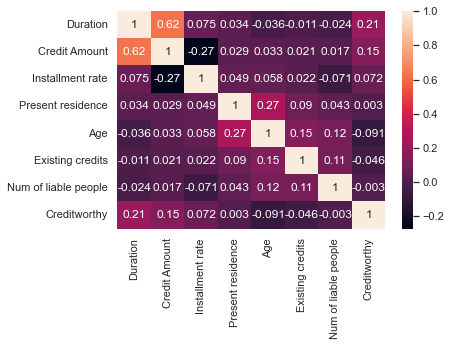

In [40]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

* Credit Amount and Duration has relatively higher linear correlation. 
* Duration and Credit Amount have relatively stronger relationship with creditworthiness than others.
* There are no perfectly related attributes, so data integration is not needed.

# Preprocessing
* Feature representation
   - Represent all of non-numerical attributes as numerical values
        - Feature normalization for numerical attributes
        - One-hot encoding for the categorical attributes 
 
* Predict missing values

First, Check how many and where missing occurs and replace them with NaN

In [41]:
# Replace "?" into Nan (Null)
df = df.replace("?", np.NAN)
df.head()

,Status,Duration,History,Purpose (incomplete),Credit Amount,Saving,Present employment (incomplete),Installment rate,Personal status & sex,Debtors / guarantors,...,Property,Age,Other Installment,Housing,Existing credits,Job (incomplete),Num of liable people,Telephone,Foreign worker (incomplete),Creditworthy
0,A14,36,A32,NaN,2299,A63,NaN,4,A93,A101,...,A123,39,A143,A152,1,A173,1,A191,NaN,1
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,...,A124,61,A143,A153,1,NaN,1,A191,A201,1
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,...,A124,38,A141,A153,1,NaN,2,A191,NaN,2
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,...,A121,33,A141,A152,2,A173,1,A191,A201,1
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,...,A123,34,A143,A152,1,A173,2,A192,A201,1


In [42]:
# Check how many NaN (missing) value exists in each attribute. 
df.isna().sum() 

Status                               0
Duration                             0
History                              0
Purpose (incomplete)               173
Credit Amount                        0
Saving                               0
Present employment (incomplete)    496
Installment rate                     0
Personal status & sex                0
Debtors / guarantors                 0
Present residence                    0
Property                             0
Age                                  0
Other Installment                    0
Housing                              0
Existing credits                     0
Job (incomplete)                   232
Num of liable people                 0
Telephone                            0
Foreign worker (incomplete)        360
Creditworthy                         0
dtype: int64

### Feature Representation
#### Normalization
The value range of numerical attributes is large, so they should be normalised. 
Since the categorical value will be one-hot encoded, all the dataset would be same range if the numerical attributes should be also scaled from 0 to 1. There is no "extreme" outliers but with some outliers. Some of the numerical value are not normally distributed, however z-score normalization treates the data as normally distributed, and scale it 0 to 1 with the standard diviation and the mean. 

In [6]:
# Normalize the numerical attributes with z_score
X = df.drop("Creditworthy", axis = 1)# Drop y label to create df which contains only features X
num_col = X.select_dtypes(include=['int64']) # numerical columns
normalized = stats.zscore(num_col) # normalized numerical columns
X[X.select_dtypes(include=['int64']).columns] = normalized # Replace numerical features columns in df with normalized value
X

,Status,Duration,History,Purpose (incomplete),Credit Amount,Saving,Present employment (incomplete),Installment rate,Personal status & sex,Debtors / guarantors,Present residence,Property,Age,Other Installment,Housing,Existing credits,Job (incomplete),Num of liable people,Telephone,Foreign worker (incomplete)
0,A14,1.252574,A32,?,-0.344610,A63,?,0.918477,A93,A101,1.046987,A123,0.303788,A143,A152,-0.704926,A173,-0.428290,A191,?
1,A12,-0.240857,A32,A46,-0.720320,A65,A73,0.918477,A93,A101,1.046987,A124,2.238742,A143,A153,-0.704926,?,-0.428290,A191,A201
2,A13,0.256953,A32,A40,-0.823818,A61,A74,0.918477,A93,A101,0.140505,A124,0.215835,A141,A153,-0.704926,?,2.334869,A191,?
3,A14,-0.489762,A33,A43,-0.635608,A61,A73,0.918477,A94,A101,0.140505,A121,-0.223927,A141,A152,1.027079,A173,-0.428290,A191,A201
4,A14,0.256953,A32,A40,-0.618950,A64,A74,0.918477,A92,A101,0.140505,A123,-0.135974,A143,A152,-0.704926,A173,2.334869,A192,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,0.008048,A32,A49,-0.602291,A64,A75,0.918477,A92,A101,1.046987,A121,0.039930,A141,A152,-0.704926,?,-0.428290,A191,?
996,A11,-1.236478,A31,A46,-0.734853,A61,A75,0.918477,A92,A101,1.046987,A124,-0.048022,A143,A153,-0.704926,A173,-0.428290,A191,A201
997,A12,-0.738668,A32,A40,-0.916682,A61,A74,-0.870183,A94,A101,0.140505,A123,-0.927547,A141,A152,-0.704926,?,-0.428290,A191,A201
998,A11,0.256953,A32,A40,-0.669989,A65,?,0.918477,A92,A101,-0.765977,A122,-0.048022,A143,A152,-0.704926,A173,-0.428290,A191,A201


####  One-hot encoding categorical attributes
To predict the missing value with linear classification, the features made of complete attributes are used as X features and incomplete attributes are used as y label. 

First, the X categorical attributes for the missing prediction should be represented as numerical values. I chose to encode with one-hot encoding since the categories does not have strict order which have a direct effect on the prediction.  

In [7]:
# One-hot encode the categorical features without missing values
incomp = ["Purpose (incomplete)", "Present employment (incomplete)", "Job (incomplete)", "Foreign worker (incomplete)"] # incomp = Attributes which has missing value
comp = X.drop(incomp, axis = 1) # comp = feature columns without missing value
cat = comp.drop(num_col.columns, axis = 1) # cat = categorical feature columns without missing value   

enc = OneHotEncoder(dtype = "int64").fit(cat)
enc_cat_cols = enc.get_feature_names_out(cat.columns)# enc_cat_cols = new columns names for one-hot encoded cat 
one_hot_encoded = pd.DataFrame(enc.transform(cat).toarray(), columns = enc_cat_cols) # Create a dataframe with one-hot encoded cat
one_hot_encoded

,Status_A11,Status_A12,Status_A13,Status_A14,History_A30,History_A31,History_A32,History_A33,History_A34,Saving_A61,...,Property_A123,Property_A124,Other Installment_A141,Other Installment_A142,Other Installment_A143,Housing_A151,Housing_A152,Housing_A153,Telephone_A191,Telephone_A192
0,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,1,0,1,0
1,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,1,0
2,0,0,1,0,0,0,1,0,0,1,...,0,1,1,0,0,0,0,1,1,0
3,0,0,0,1,0,0,0,1,0,1,...,0,0,1,0,0,0,1,0,1,0
4,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
996,1,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,1,0
997,0,1,0,0,0,0,1,0,0,1,...,1,0,1,0,0,0,1,0,1,0
998,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0


Attatch the one-hot encoded attributes with numerical attributes, so it will be an entire X feature for each missing value prediction. 

In [8]:
# attatch the one_hot_encoded with numerical value, 
enc_df = pd.concat([normalized, one_hot_encoded], axis = 1)
enc_df.head() # X feature for each missing value prediction

,Duration,Credit Amount,Installment rate,Present residence,Age,Existing credits,Num of liable people,Status_A11,Status_A12,Status_A13,...,Property_A123,Property_A124,Other Installment_A141,Other Installment_A142,Other Installment_A143,Housing_A151,Housing_A152,Housing_A153,Telephone_A191,Telephone_A192
0,1.252574,-0.344610,0.918477,1.046987,0.303788,-0.704926,-0.428290,0,0,0,...,1,0,0,0,1,0,1,0,1,0
1,-0.240857,-0.720320,0.918477,1.046987,2.238742,-0.704926,-0.428290,0,1,0,...,0,1,0,0,1,0,0,1,1,0
2,0.256953,-0.823818,0.918477,0.140505,0.215835,-0.704926,2.334869,0,0,1,...,0,1,1,0,0,0,0,1,1,0
3,-0.489762,-0.635608,0.918477,0.140505,-0.223927,1.027079,-0.428290,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,0.256953,-0.618950,0.918477,0.140505,-0.135974,-0.704926,2.334869,0,0,0,...,1,0,0,0,1,0,1,0,0,1


Check if all the X attributes are numerical values without missing values. 

In [9]:
enc_df.info() # only numerical values and no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Duration                   1000 non-null   float64
 1   Credit Amount              1000 non-null   float64
 2   Installment rate           1000 non-null   float64
 3   Present residence          1000 non-null   float64
 4   Age                        1000 non-null   float64
 5   Existing credits           1000 non-null   float64
 6   Num of liable people       1000 non-null   float64
 7   Status_A11                 1000 non-null   int64  
 8   Status_A12                 1000 non-null   int64  
 9   Status_A13                 1000 non-null   int64  
 10  Status_A14                 1000 non-null   int64  
 11  History_A30                1000 non-null   int64  
 12  History_A31                1000 non-null   int64  
 13  History_A32                1000 non-null   int64 

#### Predict missing value for each columns  
   1. "Purpose (incomplete)"
   2. "Present employment (incomplete)"
   3. "Job (incomplete)"
   4. "Foreign worker (incomplete)".  
   
Predict missing value with SVM model and Perceptron model.
Compare those models and use the higher score model for the missing value prediction. 
The score by holdout testing is pessimistic since the model was trained on the smaller size of train datset that could be used to train at maximum amount. 

In [10]:
def pred_miss(miss_col, enc):
    y_train = df[miss_col][df[miss_col].notna()] # Non-missing values in the column with missing values
    X_train = enc_df[df[miss_col].notna()] # X features for non-missing instances in the column with missing values
    X_test = enc_df[df[miss_col].isnull()] # X features for missing instances in the column with missing values
  
    # For holdout testing, separate the train set into nested_train set and 
    X_nested_train, X_nested_test, y_nested_train, y_nested_test = train_test_split(X_train, y_train, test_size=0.4)

    # Predict missing value with chosen model 1
    model_1 = SGDClassifier(loss = 'hinge', penalty='l2')
    model_1.fit(X_nested_train, y_nested_train)
    acc_1 = accuracy_score(model_1.predict(X_nested_test), y_nested_test)
    model_1.fit(X_train, y_train)
    pred_1 = pd.Series(model_1.predict(X_test), name=miss_col, index=X_test.index)
    
    # Predict missing value with chosen model 2
    model_2 = Perceptron()
    model_2.fit(X_nested_train, y_nested_train)
    acc_2 = accuracy_score(model_2.predict(X_nested_test), y_nested_test)
    model_2.fit(X_train, y_train)
    pred_2 = pd.Series(model_2.predict(X_test), name=miss_col, index=X_test.index)
    
    # Combine the predicted values_1 with y_train, so we have entire instances in the column
    non_missing_1 = pd.concat([pred_1, y_train]).sort_index()
    
    # Combine the predicted values_2 with y_train, so we have entire instances in the column
    non_missing_2 = pd.concat([pred_2, y_train]).sort_index()
    
    # One-hot Encode the entire column for model 1 prediction
    enc.fit(non_missing_1.values.reshape(-1, 1)) # reshape if the attribute is one with many instances
    enc_columns = enc.get_feature_names_out([miss_col])
    enc_non_missing_1 = pd.DataFrame(enc.fit_transform(non_missing_2.values.reshape(-1, 1)).toarray(), columns = enc_columns)
    
    # One-hot Encode the entire column for model 2 prediction
    enc.fit(non_missing_2.values.reshape(-1, 1)) # reshape if the attribute is one with many instances
    enc_columns = enc.get_feature_names_out([miss_col])
    enc_non_missing_2 = pd.DataFrame(enc.fit_transform(non_missing_2.values.reshape(-1, 1)).toarray(), columns = enc_columns)
    
    return acc_1, enc_non_missing_1, acc_2, enc_non_missing_2
    


In [11]:
# Purpose
purpose_accuracy_1, purpose_predict_1, purpose_accuracy_2, purpose_predict_2 = pred_miss("Purpose (incomplete)", enc)
print ('SVM')
print (purpose_accuracy_1)
print ('Perceptron')
print (purpose_accuracy_2)

ValueError: Found array with 0 sample(s) (shape=(0, 40)) while a minimum of 1 is required.

In [86]:
# Employment since
emp_accuracy_1, emp_predict_1, emp_accuracy_2, emp_predict_2 = pred_miss("Present employment (incomplete)", enc)
print ('SVM')
print (emp_accuracy_1)
print ('Perceptron')
print (emp_accuracy_2)

SVM
0.3316831683168317
Perceptron
0.2623762376237624


In [87]:
# Job 
job_accuracy_1, job_predict_1, job_accuracy_2, job_predict_2 = pred_miss("Job (incomplete)", enc)
print ('SVM')
print (job_accuracy_1)
print ('Perceptron')
print (job_accuracy_2)

SVM
0.6298701298701299
Perceptron
0.5357142857142857


In [89]:
# Foreign workers 
foreign_accuracy_1, foreign_predict_1, foreign_accuracy_2, foreign_predict_2 = pred_miss("Foreign worker (incomplete)", enc)
print ('SVM')
print (foreign_accuracy_1)
print ('Perceptron')
print (foreign_accuracy_2)

SVM
0.98046875
Perceptron
0.97265625


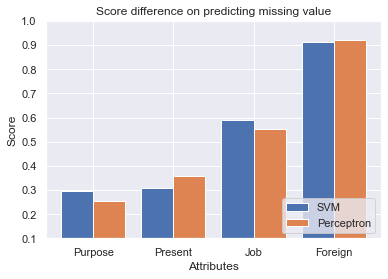

In [214]:
# Plot the score comparison between SVM and Perceptron.
names = ['Purpose', 'Present', 'Job', 'Foreign']

svm =  [purpose_accuracy_1,emp_accuracy_1, job_accuracy_1, foreign_accuracy_1]
perc =  [purpose_accuracy_2,emp_accuracy_2, job_accuracy_2, foreign_accuracy_2]

X_axis = np.arange(len(names))
plt.bar(X_axis - 0.2, svm, 0.4, label = 'SVM')
plt.bar(X_axis + 0.2, perc, 0.4, label = 'Perceptron')

plt.xticks(X_axis, names)
plt.xlabel("Attributes")
plt.ylabel("Score")
plt.title("Score difference on predicting missing value")
plt.legend(loc='lower right')
plt.ylim([0.1, 1.0])
plt.show()  

Except the attribute "Foreign workers", SVM scores are higher.
To predict the missing value, I use SVM for the first three attributes, and Perceptron for the last attribute. 

In [216]:
# put the non_missing column into the enc_df
non_missing= pd.concat([purpose_predict_1, emp_predict_1, job_predict_1, foreign_predict_2], axis=1)
new_X = pd.concat([non_missing, enc_df], axis=1) # All X attributes for predicting the creditworthiness. 
new_X.head()

,Purpose (incomplete)_A40,Purpose (incomplete)_A41,Purpose (incomplete)_A410,Purpose (incomplete)_A42,Purpose (incomplete)_A43,Purpose (incomplete)_A44,Purpose (incomplete)_A45,Purpose (incomplete)_A46,Purpose (incomplete)_A48,Purpose (incomplete)_A49,...,Property_A123,Property_A124,Other Installment_A141,Other Installment_A142,Other Installment_A143,Housing_A151,Housing_A152,Housing_A153,Telephone_A191,Telephone_A192
0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,1,0,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,1,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,1


Numerical values are normalized, categorical values with string label was one-hot encoded and the missing values are replaced with the predicted values. 

In [96]:
new_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 61 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Purpose (incomplete)_A40             1000 non-null   int64  
 1   Purpose (incomplete)_A41             1000 non-null   int64  
 2   Purpose (incomplete)_A410            1000 non-null   int64  
 3   Purpose (incomplete)_A42             1000 non-null   int64  
 4   Purpose (incomplete)_A43             1000 non-null   int64  
 5   Purpose (incomplete)_A44             1000 non-null   int64  
 6   Purpose (incomplete)_A45             1000 non-null   int64  
 7   Purpose (incomplete)_A46             1000 non-null   int64  
 8   Purpose (incomplete)_A48             1000 non-null   int64  
 9   Purpose (incomplete)_A49             1000 non-null   int64  
 10  Present employment (incomplete)_A71  1000 non-null   int64  
 11  Present employment (incomplete)

* 1000 instances with the index of 0 to 999
* The number of attributes becomes 61. 

# Identify a suitable method for the problem
* If there is a model that gives extremely higher score, use the method (f beta measure (where beta = 0.2) on K-Fold cross validation)
* Improve the selected model by hyperparameter tuning through nested cross validation
* Compare the baseline model with the improved model with tuned hyperparmeter.

First, define input X and output y. For y, since the original label is 2 (creditworthy) and 1 (not worthy), it should be encoded into positive 1 (creditworthy) and negative 0 (not worthy) for the classification label convention.

In [101]:
# Data 
X, y = new_X, label_binarize(df["Creditworthy"], classes=[2,1]).ravel()
X.shape, y.shape, y[:5]

((1000, 61), (1000,), array([1, 1, 0, 1, 1]))

### Evaluate score with F-beta score 
High precision relates to a low false positive rate, and high recall relates to a low false negative rate and the problem requirement tells that the evaluation should punish false positive (predict unworthy as crediitworthy) 5 times more than false negative (predict worthy as unworthy), which means.  
Given the F measure score $F_{α} = \frac{n_{TP} }{α(n_{TP} + n_{FP}) + (1-α)n_{TP} + n_{FN} }$, where $\alpha = \frac{1}{1*\beta}$ and  $\beta = 0.2.$, since $n_{TP} + n_{FP}$ is precision and $n_{TP} + n_{FN}$ is recall.



### K-Fold Cross Validation
Compared with estimator by holdout testing, K-Fold Cross validation has less variance on the dataset, by averaging the holdout testing score and incorporating all data into the estimator.

In [4]:
methods = {"DT": DecisionTreeClassifier(), "RF": RandomForestClassifier(), "RIDGE": RidgeClassifier(), "SVM": SGDClassifier(loss = 'hinge', penalty='l2'), "PER": Perceptron(), "MLP": MLPClassifier(max_iter=2000)}
kf_scores = {key: 0 for key in methods}

# Split the data set into K Fold  
k = 4
kf = KFold(n_splits=k)
#kf.get_n_splits(X)
KFold(n_splits=k)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    for key in methods:
        clf = methods[key]
        clf.fit(X_train, y_train)
        pred= clf.predict(X_test)
        kf_preds.append(pred)
        kf_score = fbeta_score (y_test, pred, beta = 0.2)
        kf_scores[key] += kf_score
    
for key in kf_scores:
    kf_scores[key] = kf_scores[key]/k # Average the k times added scores 

    

### Plot the scores ###
names = list(methods.keys())
#names = list(methods.keys())
kf_val = list(kf_scores.values())
plt.ylim([0.7, 0.85])
plt.bar(range(len(names)), kf_val, tick_label=names)
plt.title('Model Comparison in KFold Cross validation')

plt.show()    
    
### Print the scores ###
kf_scores

NameError: name 'X' is not defined

* Perform around 0.75 to 0.80 F-beta scores
* No large differences in the score to select the "best" model in general because of the model performance instability
* Hard to mention what is the best model without hyper-parameter tuning

* Check how hyper parameter tuning change the models' scores comparing MLPClassifier which has very different proparty compared with the models below
     * Baseline method 
        * DecisionTree
        * RandomForest 
* Assumption 
    * Hyper parameter tuning is assumed to improve the general result of decision tree and randomforest and compared with MLPClassifier
        * The dataset is not large enough to effectively apply neural networks 
        * RandomForest classifier perorms well in practice for many problems when training data is not very large
        * ex ) By giving the tree_depth to the baseline methods, models might avoid overfit. 

###### Model performance instability 
1. {'DT': 0.7721343325006939,
     'RF': 0.7832232649750899,
     'RIDGE': 0.7865386951767709,
     'SVM': 0.8215264752560958,
     'PER': 0.7834214733735089,
     'MLP': 0.8131326239294057}
     
2. {'DT': 0.7706762257488754,
     'RF': 0.7740026232405228,
     'RIDGE': 0.7949807474596241,
     'SVM': 0.7881560150829872,
     'PER': 0.8045696200461645,
     'MLP': 0.7985666709469734}
     
3. {'DT': 0.7626454436330802,
     'RF': 0.7886811172015014,
     'RIDGE': 0.7949807474596241,
     'SVM': 0.769900682216283,
     'PER': 0.8045696200461645,
     'MLP': 0.790032930231071}

4. {'DT': 0.7617710059206557,
     'RF': 0.7941662825208851,
     'RIDGE': 0.7949807474596241,
     'SVM': 0.7993529103027935,
     'PER': 0.8045696200461645,
     'MLP': 0.7987845103399063}
     
5. {'DT': 0.7646351213199318,
     'RF': 0.7869665190571026,
     'RIDGE': 0.7949807474596241,
     'SVM': 0.8067630770364708,
     'PER': 0.8045696200461645,
     'MLP': 0.7933662652344934}
     
6. {'DT': 0.7880901287553648,
     'RF': 0.7794624396967609,
     'RIDGE': 0.7865386951767709,
     'SVM': 0.7506345177664974,
     'PER': 0.7834214733735089,
     'MLP': 0.8079188071670217}


### Nested Cross Validation

Nested cross-validation (CV) is often used to train a model in which hyperparameters also need to be optimized. Nested CV estimates the generalization error of the underlying model and its (hyper)parameter search.In model selection without CV, hyperparameter information might leak into the model and overfit the data.

As in holdout testing, f-beta score (beta = 0.2) is used for the evaluation metrics.

In [26]:
scorer = make_scorer(fbeta_score, beta=0.2)

Hyperparameter choice

* MLPClassifier (Neural Network)
    - activation
        - 'identity': no activation, returns f(x) = x
        - 'logistic': the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x))
        - 'relu': the rectified linear unit function, returns f(x) = max (0, x)
        - 'tanh': similar to sigmoid but the range is from -1 to 1
    - alpha: default = 0.0001, strength of the L2 regularization term.  
    - max_iter: maximum number of iterations.
    
* RandomForestClassifier
    - n_estimators: The number of trees before taking the mazimum voting or averages of predictions. Default 100.
    - max_depth: the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_sampoles_split samples.
    - min_samples_split: The minimum number of samples required to split an internal node. 
    - min_samples_leaf: The minimum number of samples required to be at a leaf node.  
    - max_features: The maximum number of features random forest is allowed to try in individual tree. 

In [145]:
methods = [MLPClassifier(max_iter=2000), DecisionTreeClassifier(), RandomForestClassifier()]# Maximum iterations (200) reached and the optimization hasn't converged yet.

mlp = {"activation": ['relu', 'tanh'], "alpha": np.arange(0.0051, 0.01, 0.001), 'hidden_layer_sizes': np.arange(70, 110, 10)}
tree = {"min_samples_leaf": np.arange(1, 3, 1), "min_samples_split": np.arange(2, 4, 1), "max_depth": [21,23,25,27, None]}
forest = {"n_estimators": np.arange(170, 230, 10), "min_samples_leaf": np.arange(1,3,1),  "min_samples_split": np.arange(2, 4, 1), "max_depth":[21,23,25,27, None], "max_features": ["auto", "sqrt", "log2", None] }
p_grids = [mlp, tree, forest]

for i in zip(methods, p_grids):
    print (i)

(MLPClassifier(max_iter=2000), {'activation': ['relu', 'tanh'], 'alpha': array([0.0051, 0.0061, 0.0071, 0.0081, 0.0091]), 'hidden_layer_sizes': array([ 70,  80,  90, 100])})
(DecisionTreeClassifier(), {'min_samples_leaf': array([1, 2]), 'min_samples_split': array([2, 3]), 'max_depth': [21, 23, 25, 27, None]})
(RandomForestClassifier(), {'n_estimators': array([170, 180, 190, 200, 210, 220]), 'min_samples_leaf': array([1, 2]), 'min_samples_split': array([2, 3]), 'max_depth': [21, 23, 25, 27, None], 'max_features': ['auto', 'sqrt', 'log2', None]})


In [146]:
# Set up possible values of parameters to optimize over
inner_cv = KFold(n_splits=4, shuffle=True)
outer_cv = KFold(n_splits=4, shuffle=True)
best_models = {}
best_scores = {}
best_params = {}

for m_and_p in zip(methods, p_grids):   
    # Nested CV with parameter optimization
    method = m_and_p[0]
    grid_clf = GridSearchCV(estimator=method, param_grid=m_and_p[1], scoring=scorer, cv=inner_cv) # Find the best param in inner loop, give the clf
    scores = cross_val_score(grid_clf, X=X, y=y, scoring=scorer, cv=outer_cv)# Report the loss of the unseen data in the outer loop
    grid_clf.fit(X, y)# this clf compares each different hyperparameter score in entire dataset, and after that, train in entire dataset with best hyperparameter 
    best_models[method] = grid_clf.best_estimator_ # output the best model
    best_scores[method] = np.mean(scores)
    best_params[method] = grid_clf.best_params_
    print (best_scores)
    print (best_params)


{MLPClassifier(max_iter=2000): 0.8050096688021429}
{MLPClassifier(max_iter=2000): {'activation': 'tanh', 'alpha': 0.0061, 'hidden_layer_sizes': 70}}
{MLPClassifier(max_iter=2000): 0.8050096688021429, DecisionTreeClassifier(): 0.7803082130200835}
{MLPClassifier(max_iter=2000): {'activation': 'tanh', 'alpha': 0.0061, 'hidden_layer_sizes': 70}, DecisionTreeClassifier(): {'max_depth': 27, 'min_samples_leaf': 1, 'min_samples_split': 3}}
{MLPClassifier(max_iter=2000): 0.8050096688021429, DecisionTreeClassifier(): 0.7803082130200835, RandomForestClassifier(): 0.7922274397280229}
{MLPClassifier(max_iter=2000): {'activation': 'tanh', 'alpha': 0.0061, 'hidden_layer_sizes': 70}, DecisionTreeClassifier(): {'max_depth': 27, 'min_samples_leaf': 1, 'min_samples_split': 3}, RandomForestClassifier(): {'max_depth': 27, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 210}}


#### Hyperparameter-tuning history (best_models, best_scores, best_params) 

1. {LinearSVC(max_iter=5000): LinearSVC(C=1, class_weight='balanced', dual=False, max_iter=5000, penalty='l1'), Perceptron(): Perceptron(early_stopping=True)} {LinearSVC(max_iter=5000): 0.8422081056557165, Perceptron(): 0.7924247242543154} {LinearSVC(max_iter=5000): {'C': 1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'penalty': 'l1'}, Perceptron(): {'alpha': 0.0001, 'early_stopping': True}}

2. MLPClassifier(max_iter=10000)
scores: 0.784526984587685 best parameter: {'activation': 'tanh', 'alpha': 0.0001, 'learning_rate_init': 0.01} 

3.  RandomForestClassifier()
scores: 0.7877197149643707 best parameter: {'max_depth': 80, 'min_samples_leaf': 1, 'n_estimators': 104}]

4. MLPClassifier(max_iter=5000)
scores: 0.7872587971629097 best parameter: {'activation': 'relu', 'alpha': 0.01} 

5. {MLPClassifier(max_iter=2000): MLPClassifier(alpha=0.001, max_iter=2000), RandomForestClassifier(random_state=1): RandomForestClassifier(n_estimators=106, random_state=1)} {MLPClassifier(max_iter=2000): 0.7933651257415327, RandomForestClassifier(random_state=1): 0.7850707166106745} {MLPClassifier(max_iter=2000): {'activation': 'relu', 'alpha': 0.001}, RandomForestClassifier(random_state=1): {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 106}}

6. {MLPClassifier(max_iter=2000): MLPClassifier(activation='tanh', alpha=0.001, max_iter=2000), RandomForestClassifier(): RandomForestClassifier(max_depth=21, n_estimators=108)} {MLPClassifier(max_iter=2000): 0.7906186534225492, RandomForestClassifier(): 0.7807890210827709} {MLPClassifier(max_iter=2000): {'activation': 'tanh', 'alpha': 0.001}, RandomForestClassifier(): {'max_depth': 21, 'min_samples_leaf': 1, 'n_estimators': 108}}

7. {MLPClassifier(max_iter=2000): MLPClassifier(activation='tanh', max_iter=2000), RandomForestClassifier(): RandomForestClassifier(n_estimators=104)} {MLPClassifier(max_iter=2000): 0.788348896457325, RandomForestClassifier(): 0.7824543305394369} {MLPClassifier(max_iter=2000): {'activation': 'tanh', 'alpha': 0.0001}, RandomForestClassifier(): {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 104}}

8. {MLPClassifier(max_iter=2000): {'activation': 'relu', 'alpha': 0.0091},
     RandomForestClassifier(): {'max_depth': 21,
      'min_samples_leaf': 1,
      'n_estimators': 107}}
      
9. {MLPClassifier(max_iter=2000): 0.7903029435040468, RandomForestClassifier(): 0.7813801662943023}
    {MLPClassifier(max_iter=2000): {'activation': 'tanh', 'alpha': 0.0051}, RandomForestClassifier(): {'max_depth': 21, 'min_samples_leaf': 1, 'n_estimators': 160}}
    
10. {MLPClassifier(max_iter=2000): 0.7893089104542566}
    {MLPClassifier(max_iter=2000): {'activation': 'tanh', 'alpha': 0.0071, 'hidden_layer_sizes': 70}}
    {MLPClassifier(max_iter=2000): 0.7893089104542566, DecisionTreeClassifier(): 0.7860511110560273}
    {MLPClassifier(max_iter=2000): {'activation': 'tanh', 'alpha': 0.0071, 'hidden_layer_sizes': 70}, DecisionTreeClassifier(): {'max_depth': 23, 'min_samples_leaf': 1, 'min_samples_split': 8}}
    {MLPClassifier(max_iter=2000): 0.7893089104542566, DecisionTreeClassifier(): 0.7860511110560273, RandomForestClassifier(): 0.7872172530786602}
    {MLPClassifier(max_iter=2000): {'activation': 'tanh', 'alpha': 0.0071, 'hidden_layer_sizes': 70}, DecisionTreeClassifier(): {'max_depth': 23, 'min_samples_leaf': 1, 'min_samples_split': 8}, RandomForestClassifier(): {'max_depth': 23, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 190}}
    
11. {MLPClassifier(max_iter=2000): 0.8050096688021429}
{MLPClassifier(max_iter=2000): {'activation': 'tanh', 'alpha': 0.0061, 'hidden_layer_sizes': 70}}
{MLPClassifier(max_iter=2000): 0.8050096688021429, DecisionTreeClassifier(): 0.7803082130200835}
{MLPClassifier(max_iter=2000): {'activation': 'tanh', 'alpha': 0.0061, 'hidden_layer_sizes': 70}, DecisionTreeClassifier(): {'max_depth': 27, 'min_samples_leaf': 1, 'min_samples_split': 3}}
{MLPClassifier(max_iter=2000): 0.8050096688021429, DecisionTreeClassifier(): 0.7803082130200835, RandomForestClassifier(): 0.7922274397280229}
{MLPClassifier(max_iter=2000): {'activation': 'tanh', 'alpha': 0.0061, 'hidden_layer_sizes': 70}, DecisionTreeClassifier(): {'max_depth': 27, 'min_samples_leaf': 1, 'min_samples_split': 3}, RandomForestClassifier(): {'max_depth': 27, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 210}}

In [147]:
#print (best_models, best_scores, best_params)
best_params

{MLPClassifier(max_iter=2000): {'activation': 'tanh',
  'alpha': 0.0061,
  'hidden_layer_sizes': 70},
 DecisionTreeClassifier(): {'max_depth': 27,
  'min_samples_leaf': 1,
  'min_samples_split': 3},
 RandomForestClassifier(): {'max_depth': 27,
  'max_features': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 210}}

## Score Comparison with and without tuned hyper parameter
#### Holdout with/without hyperparameter

In [148]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

methods = {"DT": DecisionTreeClassifier(), "RF": RandomForestClassifier(), "MLP": MLPClassifier(max_iter=2000)}
hyper_methods = {"DT": DecisionTreeClassifier(max_depth= 27, min_samples_leaf= 1, min_samples_split = 3), "RF": RandomForestClassifier(max_depth= 27,max_features=None, min_samples_leaf= 1, min_samples_split=2, n_estimators= 210), "MLP": MLPClassifier(max_iter=2000,  activation='tanh', alpha=0.0061, hidden_layer_sizes=70)}

holdout_scores = {}
hyper_holdout_scores = {}

for method in methods:
    clf = methods[method]
    clf.fit(X_train, y_train)
    clfs.append(clf)
    pred= clf.predict(X_test)
    preds.append(pred)
    holdout_score = fbeta_score (y_test, pred, beta = 0.2)
    holdout_scores[method] = holdout_score
    #print (method, ":", score)
    

for method in hyper_methods:
    hyper_clf = hyper_methods[key]
    hyper_clf.fit(X_train, y_train)
    hyper_pred = hyper_clf.predict(X_test)
    hyper_holdout_score = fbeta_score (y_test, hyper_pred, beta = 0.2)
    hyper_holdout_scores[method] = hyper_holdout_score


print ("holdout_scores: ", holdout_scores)
print ("hyper_holdout_scores: ", hyper_holdout_scores)

holdout_scores:  {'DT': 0.7863894139886579, 'RF': 0.7749537892791127, 'MLP': 0.8061262607396339}
hyper_holdout_scores:  {'DT': 0.8014033329156748, 'RF': 0.8027158595951832, 'MLP': 0.8153193676905283}


#### KFold with/without hyperparameter

In [222]:
methods = {"DT": DecisionTreeClassifier(),"RF": RandomForestClassifier(), "MLP": MLPClassifier(max_iter=2000)}
kf_scores = {key: 0 for key in methods}
#hyper_methods = {"DT": DecisionTreeClassifier(max_depth= 23, min_samples_leaf= 1, min_samples_split = 8), "RF": RandomForestClassifier(max_depth= 23, min_samples_leaf= 1, min_samples_split=2, n_estimators= 190), "MLP": MLPClassifier(max_iter=2000,  activation='tanh', alpha=0.0071)}
hyper_methods = {"DT": DecisionTreeClassifier(max_depth= 27, min_samples_leaf= 1, min_samples_split = 3), "RF": RandomForestClassifier(max_depth= 27,max_features=None, min_samples_leaf= 1, min_samples_split=2, n_estimators= 210), "MLP": MLPClassifier(max_iter=2000,  activation='tanh', alpha=0.0061, hidden_layer_sizes=70)}
kf_hyper_scores = {key: 0 for key in methods}

# Split the data set into K Fold  
k = 4
kf = KFold(n_splits=k)
#kf.get_n_splits(X)
KFold(n_splits=k)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
   
    #kf_preds = []
    #kf_clfs = []
    #print (kf_scores)    
        
    for key in methods:
        clf = methods[key]
        clf.fit(X_train, y_train)
        pred= clf.predict(X_test)
        kf_score = fbeta_score (y_test, pred, beta = 0.2)
        kf_scores[key] += kf_score
     
    for key in hyper_methods:
        hyper_clf = hyper_methods[key]
        hyper_clf.fit(X_train, y_train)
        hyper_pred = hyper_clf.predict(X_test)
        kf_hyper_score = fbeta_score (y_test, hyper_pred, beta = 0.2)
        kf_hyper_scores[key] += kf_hyper_score
    
print ("kf sum: ", kf_scores)    
print ("hyper_kf sum: ", kf_hyper_scores)# Scores added through each k fold test set
    
for key in kf_scores:
    kf_scores[key] = kf_scores[key]/k # Average the k times added scores 

for key in kf_hyper_scores:
    kf_hyper_scores[key] = kf_hyper_scores[key]/k # Average the k times added scores 
    
print ("kf ", kf_scores)
print ("kf_hyper: ", kf_hyper_scores)

kf sum:  {'DT': 3.0291024296133324, 'RF': 3.125632055920337, 'MLP': 3.221664876260009}
hyper_kf sum:  {'DT': 3.053301625085571, 'RF': 3.1943969454220067, 'MLP': 3.187737832308286}
kf  {'DT': 0.7572756074033331, 'RF': 0.7814080139800843, 'MLP': 0.8054162190650023}
kf_hyper:  {'DT': 0.7633254062713928, 'RF': 0.7985992363555017, 'MLP': 0.7969344580770715}


#### Plot Holdout testing score with/without hyperparmeter 

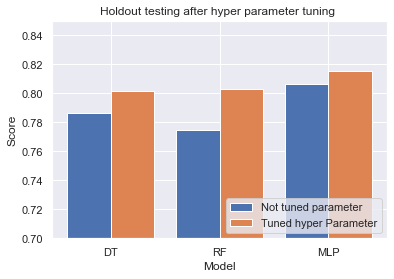

In [150]:
# How the model improves with hyperparmeter tuning? 
names = ['DT','RF', 'MLP']
holdout = [ holdout_scores['DT'],holdout_scores['RF'], holdout_scores['MLP'],]
hyper_holdout = [hyper_holdout_scores['DT'],hyper_holdout_scores['RF'], hyper_holdout_scores['MLP']]
X_axis = np.arange(len(names))
plt.bar(X_axis - 0.2, holdout, 0.4, label = 'Not tuned parameter')
plt.bar(X_axis + 0.2, hyper_holdout, 0.4, label = 'Tuned hyper Parameter')
  
plt.xticks(X_axis, names)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Holdout testing after hyper parameter tuning ")
plt.legend(loc='lower right')
plt.ylim([0.7, 0.85])
plt.show()  

#### Plot Kfold cross val score with/without hyperparmeter 


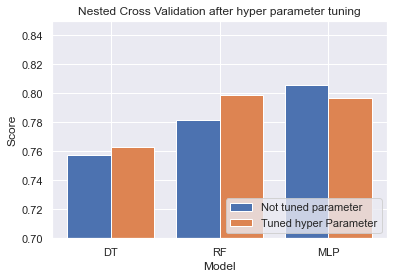

In [224]:
# How the model improves with hyperparmeter tuning? 
names = ['DT', 'RF', 'MLP',]
kf = [kf_scores['DT'], kf_scores['RF'], kf_scores['MLP']]
hyper_kf = [kf_hyper_scores['DT'], kf_hyper_scores['RF'], kf_hyper_scores['MLP']]
X_axis = np.arange(len(names))
plt.bar(X_axis - 0.2, kf, 0.4, label = 'Not tuned parameter')
plt.bar(X_axis + 0.2, hyper_kf, 0.4, label = 'Tuned hyper Parameter')
  
plt.xticks(X_axis, names)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("K-Fold cross Validation after hyper parameter tuning")
plt.legend(loc='lower right')
plt.ylim([0.7, 0.85])
plt.show()  

#### Why hyper parameter tuning improved the model ?
* DT: Hyper-parameter suppress the overfitting 
    * Min_samples_splits = 3 (among 1 to 10, def 2)
    * Max_depth = 23 (When def None, nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.) 
* RF: Hyper-parameter suppress the overfitting 
    * n_estimators= 190 

#### Why hyper parameter tuning did improve the model? 
* MLP: Default Parameter already adapt to the best performance
    * Batch_size = ‘auto’ : batch_size=min(200, n_samples)
    * solver’= ‘adam’ refers to a stochastic gradient-based optimize
    * solver = ‘lbfgs’ might have worked better for small datasets, where it does not use stochastic gradient descent.
